In [1]:
import json
import torch
import numpy as np
import matplotlib.pyplot as plt

from torch import nn
from tqdm import tqdm
from sklearn.datasets import make_blobs
from sklearn.mixture import GaussianMixture

from model import LUNet, register_activation_hooks
from model_inverse import InverseLUNet
from functions import neg_log_likelihood

'''hyperparameters'''
batch_size = 5000
random_seed = 14
leaky_learn = True
num_lu_blocks = 16
layer_size = 2
alpha = 0.5
raw_alpha = torch.logit(torch.tensor(alpha)) # if sigmoid slope transform is used

/homes/math/chan/.conda/envs/6d-pose/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
'''set random seeds and device'''
torch.manual_seed(random_seed)
torch.cuda.manual_seed(random_seed)
torch.cuda.manual_seed_all(random_seed)
device = torch.device(
    "cuda:0" if torch.cuda.is_available()
    else ("mps" if torch.backends.mps.is_available() and torch.backends.mps.is_built()
    else "cpu")
    ) # Use CUDA if available, otherwise use MPS if available, else use CPU
print(f"Using device: {device}")

Using device: cuda:0


In [3]:
def generate_gaussian(n_samples=5000, centers=4, random_state=12):
    """generate two dimensional gaussian data"""
    X, _ = make_blobs(n_samples=n_samples, center_box=(-5.0, 5.0), centers=centers, cluster_std=0.20, random_state=random_state)
    return torch.tensor(X).float()

data = generate_gaussian(n_samples=batch_size, random_state=random_seed).double()
print(f'{data.shape=}') # (5000, 2)

data.shape=torch.Size([5000, 2])


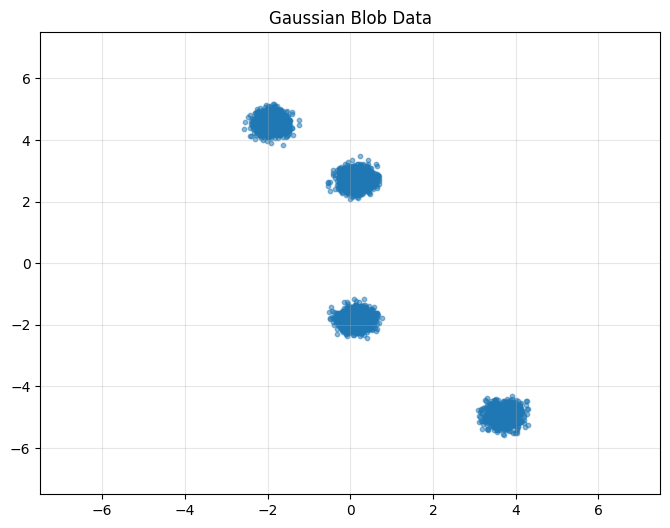

In [4]:
'''plot the Gaussian blob training data'''
plt.figure(figsize=(8, 6))
plt.scatter(data[:, 0], data[:, 1], alpha=0.5, s=10)
plt.title('Gaussian Blob Data')
plt.grid(True, alpha=0.3)
plt.xlim(-7.5, 7.5)
plt.ylim(-7.5, 7.5)
plt.show()

In [5]:
'''initialize model and optimizer'''
model = LUNet(num_lu_blocks, layer_size, leaky_learn, raw_alpha, device)
model.train()
model.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-1, betas=(0.9, 0.999), amsgrad=True)

'''prepare training data: shuffle, standardize, convert'''
train_data = data[torch.randperm(data.size(0))]
train_data_mean = train_data.mean(dim=0)
train_data_std = train_data.std(dim=0)
train_data = (train_data - train_data_mean) / train_data_std
train_data = train_data.float().to(device)
print(f'... prepared training data')

/net/homes/math/chan/repos/dense-lu-net-2d/functions.py:20: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.raw_alpha = nn.Parameter(torch.full((num_features,), torch.tensor(alpha)), requires_grad=True)


... initialized LUNet
... prepared training data


In [6]:
def training_routine(num_epochs=1000, lr_decay=None, device='cpu'):
    '''training routine for LU-Net model'''
    loss_logger = []
    pbar = tqdm(range(1, num_epochs + 1))
    for epoch in pbar:
        if lr_decay is not None and epoch in lr_decay['epoch']:
            learning_rate = lr_decay['lr'][lr_decay['epoch'].index(epoch)]
            for group in optimizer.param_groups:
                group['lr'] = learning_rate
            print(f"Epoch {epoch}: learning rate set to {learning_rate}")
        saved_layers, hooks = register_activation_hooks(model, layer_name='storage')
        inputs = train_data.to(device).float()
        optimizer.zero_grad(set_to_none=True)
        output = model(inputs)
        _, layer_size = output.shape
        loss = neg_log_likelihood(output, model, saved_layers, device)
        loss_logger.append(loss.item() /  (batch_size * layer_size))
        loss.backward()
        nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0, norm_type=1)
        optimizer.step()
        pbar.set_postfix({"Batch loss": "{:.4f}".format(loss.item() / (batch_size * layer_size))})
        # Remove hooks to avoid memory issues
        for h in hooks:
            h.remove()

    return loss_logger

In [ ]:
'''freeze alpha parameters for base training'''
for name, param in model.named_parameters():
    if 'alpha' in name:
        param.requires_grad = False

num_params = sum(p.numel() for p in model.parameters())
num_trainable = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"Total weights: {num_params}, trainable: {num_trainable}")

lr_decay_base = {
    'epoch': [3000, 6000, 8000],
    'lr': [1e-2, 1e-3, 1e-4]
}

lr_decay_vanilla = {
    'epoch': [1000, 3000],
    'lr': [1e-5, 1e-6]
}

'''base training followed by vanilla training'''
loss_logger = training_routine(num_epochs=9000, lr_decay=lr_decay_base, device=device)

params = model.state_dict()
torch.save(params, f"checkpoints/trained_lunet_2d_base.pth")
optimizer_state = optimizer.state_dict()
torch.save(optimizer_state, f"checkpoints/optimizer_lunet_2d_base.pth")
print(f"Saved model and optimizer state for base training.")

loss_logger_vanilla = loss_logger.copy()
loss_logger_vanilla += training_routine(num_epochs=6000, lr_decay=lr_decay_vanilla, device=device)
params = model.state_dict()
torch.save(params, f"checkpoints/trained_lunet_2d_vanilla.pth")
with open("log/loss_logger_vanilla.json", "w") as f:
    json.dump(loss_logger_vanilla, f)

print(f"Saved model and logger for vanilla training.")

Total weights: 202, trainable: 170


 33%|███▎      | 3006/9000 [01:07<02:13, 44.93it/s, Batch loss=-0.5390]

Epoch 3000: learning rate set to 0.01


 67%|██████▋   | 6006/9000 [02:13<01:06, 44.81it/s, Batch loss=-0.7167]

Epoch 6000: learning rate set to 0.001


 89%|████████▉ | 8006/9000 [02:57<00:22, 45.17it/s, Batch loss=-0.7350]

Epoch 8000: learning rate set to 0.0001


100%|██████████| 9000/9000 [03:19<00:00, 45.18it/s, Batch loss=-0.7373]


Saved model and optimizer state for base training.


 17%|█▋        | 1005/6000 [00:22<01:50, 45.20it/s, Batch loss=-0.7392]

Epoch 1000: learning rate set to 1e-05


 50%|█████     | 3005/6000 [01:06<01:07, 44.35it/s, Batch loss=-0.7403]

Epoch 3000: learning rate set to 1e-06


100%|██████████| 6000/6000 [02:12<00:00, 45.40it/s, Batch loss=-0.7404]

Saved model and logger for vanilla training.


In [ ]:
'''start refined training from base model'''
params = torch.load("checkpoints/trained_lunet_2d_base.pth")
model.load_state_dict(params)
optimizer_state = torch.load("checkpoints/optimizer_lunet_2d_base.pth")
optimizer.load_state_dict(optimizer_state)

for name, param in model.named_parameters():
    if 'alpha' in name:
        param.requires_grad = True

num_params = sum(p.numel() for p in model.parameters())
num_trainable = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"Total weights: {num_params}, trainable: {num_trainable}")

lr_decay_refined = {
    'epoch': [1, 1000, 4000, 5000],
    'lr': [2e-3, 1e-3, 1e-4, 1e-5]
}

loss_logger_refined = loss_logger.copy()
loss_logger_refined += training_routine(num_epochs=6000, lr_decay=lr_decay_refined, device=device)
params = model.state_dict()
torch.save(params, f"checkpoints/trained_lunet_2d_refined.pth")
with open("log/loss_logger_refined.json", "w") as f:
    json.dump(loss_logger_refined, f)

print(f"Saved model and logger for refined training.")

Total weights: 202, trainable: 202


  0%|          | 4/6000 [00:00<02:33, 39.12it/s, Batch loss=-0.7374]

Epoch 1: learning rate set to 0.002


 17%|█▋        | 1003/6000 [00:24<02:01, 41.26it/s, Batch loss=-0.7451]

Epoch 1000: learning rate set to 0.001


 67%|██████▋   | 4007/6000 [01:39<00:47, 41.67it/s, Batch loss=-0.7736]

Epoch 4000: learning rate set to 0.0001


 83%|████████▎ | 5006/6000 [02:03<00:24, 40.42it/s, Batch loss=-0.7779]

Epoch 5000: learning rate set to 1e-05


100%|██████████| 6000/6000 [02:28<00:00, 40.42it/s, Batch loss=-0.7782]

Saved model and logger for refined training.


In [9]:
params = torch.load("checkpoints/trained_lunet_2d_refined.pth")
inverse_model = InverseLUNet(num_lu_blocks=num_lu_blocks, params=params)
inverse_model.eval()

... initialized inverse LUNet


InverseLUNet(
  (inverse_lu_blocks): ModuleList(
    (0): InverseLowerLayer()
    (1): InverseUpperLayer()
    (2): InverseLeakySoftplus()
    (3): InverseLowerLayer()
    (4): InverseUpperLayer()
    (5): InverseLeakySoftplus()
    (6): InverseLowerLayer()
    (7): InverseUpperLayer()
    (8): InverseLeakySoftplus()
    (9): InverseLowerLayer()
    (10): InverseUpperLayer()
    (11): InverseLeakySoftplus()
    (12): InverseLowerLayer()
    (13): InverseUpperLayer()
    (14): InverseLeakySoftplus()
    (15): InverseLowerLayer()
    (16): InverseUpperLayer()
    (17): InverseLeakySoftplus()
    (18): InverseLowerLayer()
    (19): InverseUpperLayer()
    (20): InverseLeakySoftplus()
    (21): InverseLowerLayer()
    (22): InverseUpperLayer()
    (23): InverseLeakySoftplus()
    (24): InverseLowerLayer()
    (25): InverseUpperLayer()
    (26): InverseLeakySoftplus()
    (27): InverseLowerLayer()
    (28): InverseUpperLayer()
    (29): InverseLeakySoftplus()
    (30): InverseLowerLayer()
 

In [10]:
'''estimate mean and covariance of output distribution'''
output = model(train_data.to(device).float()).detach()
mean = torch.mean(output, 0)
cov = torch.cov(torch.t(output))
U, S, Vh = torch.linalg.svd(cov)
print("SVD correct: " + str(torch.dist(cov, U @ torch.diag(S) @ Vh)))
cov_sqrt = U @ torch.sqrt(torch.diag(S)) @ Vh
print("Correctness square value: " + str(torch.dist(cov, cov_sqrt @ cov_sqrt)))

SVD correct: tensor(6.4631e-07, device='cuda:0')
Correctness square value: tensor(1.0391e-06, device='cuda:0')


In [11]:
'''sample from learned distribution using the inverse model'''
normal_corr = torch.randn(batch_size, layer_size).to(device) @ cov_sqrt + mean

if torch.backends.mps.is_built():
    '''change from mps to cpu as some operations not supported on mps'''
    device = 'cpu'
    print(f"Changed device for sampling: {device}")

normal_corr = normal_corr.to(device).float()
inverse_model.to(device)
samples = inverse_model(normal_corr, device=device)
samples = samples.detach().cpu()

generated = samples * train_data_std + train_data_mean
generated = generated.numpy()
# Filter out NaN values and outliers
generated = generated[~np.isnan(generated).any(axis=1)]
generated = generated[(generated[:, 0] >= -7.5) & (generated[:, 0] <= 7.5) & 
                     (generated[:, 1] >= -7.5) & (generated[:, 1] <= 7.5)]

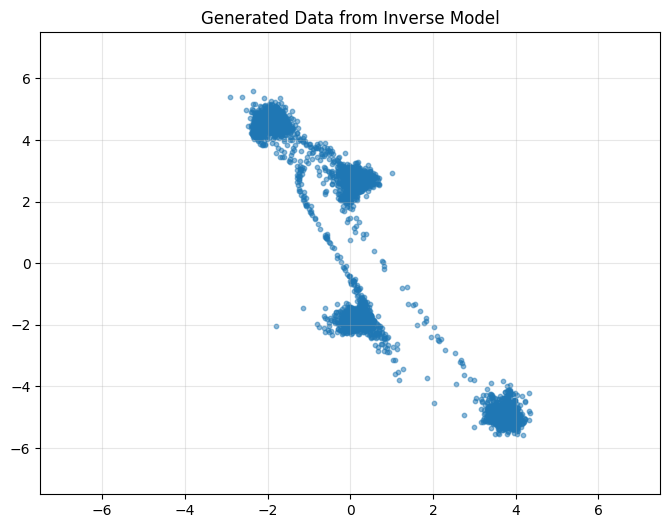

In [12]:
'''plot the generated data from inverse model'''
plt.figure(figsize=(8, 6))
plt.scatter(generated[:, 0], generated[:, 1], alpha=0.5, s=10)
plt.title('Generated Data from Inverse Model')
plt.xlim(-7.5, 7.5)
plt.ylim(-7.5, 7.5)
plt.grid(True, alpha=0.3)
plt.show()

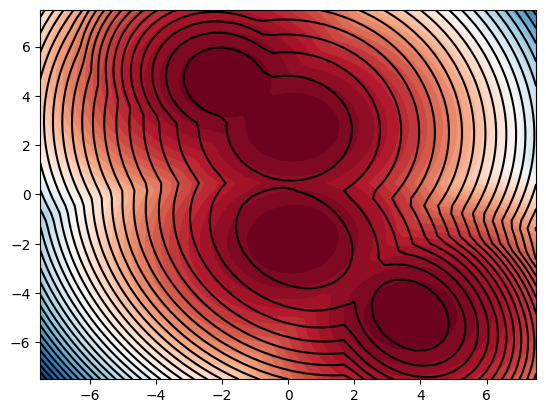

In [13]:
'''create heatmap of training data, approximation with Gaussian Mixture Model'''
clf_train = GaussianMixture(n_components=4, covariance_type="full")
clf_train.fit(torch.Tensor(data))

x = np.linspace(-7.5, 7.5)
y = np.linspace(-7.5, 7.5)
X, Y = np.meshgrid(x, y)
XX = np.array([X.ravel(), Y.ravel()]).T
nll_train = -clf_train.score_samples(XX) # nll per example
Z = nll_train.reshape(X.shape)
plt.contourf(X, Y, Z, levels = 50, cmap="RdBu")

'''create contour plot of learned distribution, approximation with Gaussian Mixture Model'''
clf_learned = GaussianMixture(n_components=4, covariance_type="full")
clf_learned.fit(generated)
nll_learned = -clf_learned.score_samples(XX) 
Z = nll_learned.reshape(X.shape)

plt.contour(X, Y, Z, levels=40, colors="black")

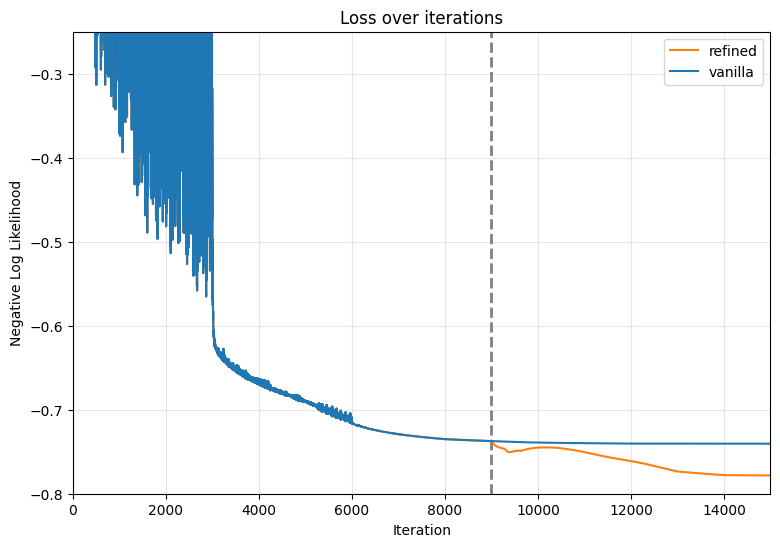

In [ ]:
with open("log/loss_logger_refined.json", "r") as f:
    loss_logger_refined = json.load(f)
with open("log/loss_logger_vanilla.json", "r") as f:
    loss_logger_vanilla = json.load(f)

'''plot loss curves for vanilla and refined training'''
plt.figure(figsize=(9, 6))
plt.axvline(x=9000, color='grey', linestyle='--', linewidth=2)
plt.plot(loss_logger_refined, color='C1', label='refined')
plt.plot(loss_logger_vanilla, color='C0', label='vanilla')
plt.title('Loss over iterations')
plt.xlabel('Iteration')
plt.ylabel('Negative Log Likelihood')
plt.xlim(0, len(loss_logger_refined))
plt.ylim(-0.8, -0.25)
plt.grid(True, alpha=0.3)
plt.legend()
plt.show()

In [15]:
'''compute KL divergence between distributions'''
train_log_p = clf_train.score_samples(data)
learned_log_p = clf_learned.score_samples(data)
kl = np.mean(train_log_p - learned_log_p)
print(f"KL divergence between true and learned distribution: {kl}")

KL divergence between true and learned distribution: 0.314457975084732
